# Recommendation Engine using Word2Vec

We are going to create a recommender engine using Word2Vec. 

The items bought together by one customer will be considered as one sentence. 

If we can represent each item by a vector then we can easily find a similar product.

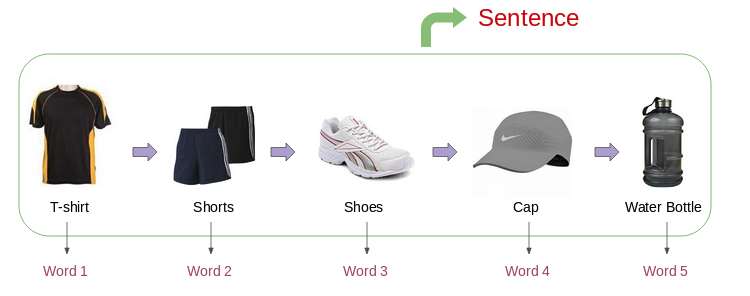

In [119]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

In [22]:
df = pd.read_excel('Online Retail.xlsx')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [19]:
#Pre-Processing and Data Cleaning
print(df.isnull().sum())

# remove missing values
df.dropna(inplace=True)

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [35]:
# If we explore the data further, we'll notice some invoices are identified with 'C'or 'A' at the ending, which denote "irregular" tranactions, so we will drop those
check = df['InvoiceNo'].copy()
print(len(check[check.str.len() > 6]) )
print(len(check[check.str.len() < 6]) )

df['CustomerID'] = df['CustomerID'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')

df = df[~df['InvoiceNo'].str.contains('A')]
df = df[~df['InvoiceNo'].str.contains('C')]

9291
0


In [42]:
#This is just simpler to view than the entire df, we can work with this from now on
df2 = df[['CustomerID','StockCode','Description']]
df2

,CustomerID,StockCode,Description
0,17850.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,17850.0,71053,WHITE METAL LANTERN
2,17850.0,84406B,CREAM CUPID HEARTS COAT HANGER
3,17850.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,17850.0,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...,...
541904,12680.0,22613,PACK OF 20 SPACEBOY NAPKINS
541905,12680.0,22899,CHILDREN'S APRON DOLLY GIRL
541906,12680.0,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,12680.0,23255,CHILDRENS CUTLERY CIRCUS PARADE


In [43]:
customer_purchases_total = df2.groupby('CustomerID')['StockCode'].apply(list)
customer_purchases_total

CustomerID
12346.0                                              [23166]
12347.0    [85116, 22375, 71477, 22492, 22771, 22772, 227...
12348.0    [84992, 22951, 84991, 84991, 21213, 21213, 226...
12349.0    [23112, 23460, 21564, 21411, 21563, 22131, 221...
12350.0    [21908, 22412, 79066K, 79191C, 22348, 84086C, ...
                                 ...                        
18281.0    [22037, 22716, 22028, 23007, 23008, 23209, 22467]
18282.0    [21270, 23187, 23295, 22089, 21108, 21109, 224...
18283.0    [22356, 20726, 22384, 22386, 20717, 20718, 850...
18287.0    [22755, 22754, 22753, 22756, 22758, 22757, 227...
nan        [22139, 21773, 21774, 21786, 21787, 21790, 217...
Name: StockCode, Length: 4340, dtype: object

In [51]:
#Determining how many values to allocate to the training set, 90% in this case
0.9*len(customer_purchases_total)

3906.0

In [58]:
customer_train = customer_purchases_total[0:3906] #90% goes to the train set
customer_test = customer_purchases_total[3906::] #10% goes to the test set

In [71]:
#Build the model, we'll keep it simple and stick to many of the defaults

w2v_model = Word2Vec(min_count=1)
w2v_model.build_vocab(customer_train)
w2v_model.train(customer_train, total_examples = w2v_model.corpus_count, 
            epochs=10, report_delay=1)

(3536796, 3561860)

In [72]:
print(w2v_model)

Word2Vec(vocab=3642, size=100, alpha=0.025)


In [73]:
# extract all vectors
X = w2v_model[w2v_model.wv.vocab]

X.shape

<ipython-input-73-61da16472fa7>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = w2v_model[w2v_model.wv.vocab]


(3642, 100)

In [103]:
customer_train.index[-1]

'17690.0'

In [89]:
# The first 90% of the products were used in the training set, or up until customerID 17690
products = df2[df2['CustomerID'].isin(customer_train.index)]

# Remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create a product-description dictionary as follows
product_desc = products.groupby('StockCode')['Description'].apply(list).to_dict()

<ipython-input-89-65236a29b920>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.drop_duplicates(inplace=True, subset='StockCode', keep="last")


In [95]:
products

,CustomerID,StockCode,Description
107,15311.0,84854,GIRLY PINK TOOL SET
2313,13777.0,82615,PINK MARSHMALLOW SCARF KNITTING KIT
2399,17069.0,21777,RECIPE BOX WITH METAL HEART
2457,14606.0,21488,RED WHITE SCARF HOT WATER BOTTLE
3790,16752.0,21769,VINTAGE POST OFFICE CABINET
...,...,...,...
541904,12680.0,22613,PACK OF 20 SPACEBOY NAPKINS
541905,12680.0,22899,CHILDREN'S APRON DOLLY GIRL
541906,12680.0,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,12680.0,23255,CHILDRENS CUTLERY CIRCUS PARADE


In [111]:
#Sample the dictionary
product_desc['21488']

['RED WHITE SCARF  HOT WATER BOTTLE']

In [113]:
# Let's see what w2v has marked as a similar item
product_desc[w2v_model.similar_by_vector('21488')[0][0]]

<ipython-input-113-c37ae3d7e880>:2: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  product_desc[w2v_model.similar_by_vector('21488')[0][0]]


['KNITTED UNION FLAG HOT WATER BOTTLE']

In [123]:
# Create a function to suggest products to a customer based on what they have purchased in the past


def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = w2v_model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (product_desc[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms



def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(w2v_model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [124]:
# Now let's use the test set, and recommend products based on the history of the customer

similar_products(aggregate_vectors(customer_test[0]))

<ipython-input-123-c3fd4e22db05>:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  product_vec.append(w2v_model[i])
<ipython-input-123-c3fd4e22db05>:7: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  ms = w2v_model.similar_by_vector(v, topn= n+1)[1:]


[('CREAM SWEETHEART LETTER RACK', 0.6918231248855591),
 ('VICTORIAN SEWING BOX SMALL ', 0.6848946809768677),
 ('LILAC GAUZE BUTTERFLY LAMPSHADE', 0.6839414834976196),
 ('YELLOW FLOWERS FELT HANDBAG KIT', 0.6718734502792358),
 ('DANISH ROSE BEDSIDE CABINET', 0.6686185002326965),
 ('SET/4 GARDEN ROSE DINNER CANDLE', 0.6635211110115051)]

In [126]:
similar_products(aggregate_vectors(customer_test[0][-5:]))

<ipython-input-123-c3fd4e22db05>:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  product_vec.append(w2v_model[i])
<ipython-input-123-c3fd4e22db05>:7: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  ms = w2v_model.similar_by_vector(v, topn= n+1)[1:]


[('YELLOW FLOWERS FELT HANDBAG KIT', 0.7778565883636475),
 ('CAKES AND RABBITS DESIGN FLANNEL ', 0.770463228225708),
 ('WHITE/PINK CHICK EASTER DECORATION', 0.7612491846084595),
 ('HEN HOUSE WITH CHICK STANDING', 0.7612363696098328),
 ('PINK FLOWERS RABBIT EASTER', 0.7589578628540039),
 ('PIN CUSHION BABUSHKA BLUE', 0.7481902837753296)]